In [1]:
# library imports
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor

# just for jupyter notebooks plot size
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
# helper function, generate lagged datasets for testing on vintages
def gen_lagged_data(metadata, data, last_date, lag):
    # only go up to the last date
    lagged_data = data.loc[data.date <= last_date, :].reset_index(drop=True)
    for col in lagged_data.columns[1:]:
        pub_lag = metadata.loc[metadata.series == col, "months_lag"].values[0] # publication lag of this particular variable
        # go back as far as needed for the pub_lag of the variable, then + the lag (so -2 for 2 months back), also -1 because 0 lag means in month, last month data available, not current month in
        lagged_data.loc[(len(lagged_data) - pub_lag + lag - 1) :, col] = np.nan

    return lagged_data

# helper function, flatten a dataset for methods that don't do timeseries, extra columns for each lag
def flatten_data(data, target_variable, n_lags):
    flattened_data = data.loc[~pd.isna(data[target_variable]), :]
    orig_index = flattened_data.index
    for i in range(1, n_lags + 1):
        lagged_indices = orig_index - i
        lagged_indices = lagged_indices[lagged_indices >= 0]
        tmp = data.loc[lagged_indices, :]
        tmp.date = tmp.date + pd.DateOffset(months=i)
        tmp = tmp.drop([target_variable], axis=1)
        tmp.columns = [j + "_" + str(i) if j != "date" else j for j in tmp.columns]
        flattened_data = flattened_data.merge(tmp, how="left", on="date")

    return flattened_data

# helper function fill missings in a dataset with the mean from the training set
def mean_fill_dataset(training, test):
    mean_dict = {}
    for col in training.columns[1:]:
        mean_dict[col] = np.nanmean(training[col])
    filled = test.copy()
    for col in training.columns[1:]:
        filled.loc[pd.isna(filled[col]), col] = mean_dict[col]
    return filled

# Data set up

In [3]:
# data read
data = pd.read_csv("../data/data_tf.csv", parse_dates=["date"])
metadata = pd.read_csv("../data/meta_data.csv")

# target variable = GDP
target_variable = "gdpc1"

# which artificial lags to test the model on, equivalent to number of months ahead of and behind the target date (e.g. 2020-06-01 for Q2 2020)
lags = list(range(-2, 3))

# train and test dates
train_start_date = "1947-01-01"
train_end_date = "2004-12-01"
test_start_date = "2005-03-01"
test_end_date = "2010-12-01"

# train and test datasets
train = data.loc[(data.date >= train_start_date) & (data.date <= train_end_date), :].reset_index(drop=True)
test = data.loc[(data.date >= train_start_date) & (data.date <= test_end_date), :].reset_index(drop=True) # let test set data begin from training begin, data lag/time series for test sets can go back into the training data

Data should be a dataframe of seasonally adjusted growth rates with months in rows and quarterly variables in the last month of the quarter, with `np.nan`s for interquarter months.

In [4]:
data.tail()

,date,payems,gdpc1,cpiaucsl,unrate,houst,indpro,dspic96,cpilfesl,pcepilfe,pcepi,permit,ulcnfb,a261rx1q020sbea
896,2021-09-01,0.002570,0.005709,0.004124,-0.096154,-0.014622,-0.009759,-0.016185,0.002431,0.002405,0.003465,-0.078443,0.023111,0.014297
897,2021-10-01,0.004383,NaN,0.009433,-0.021277,0.001290,0.012333,-0.001650,0.005992,0.004427,0.006487,0.042245,NaN,NaN
898,2021-11-01,0.001677,NaN,0.007791,-0.086957,0.081186,0.007375,-0.001950,0.005346,0.004803,0.006266,0.038717,NaN,NaN
899,2021-12-01,0.001338,0.016791,0.004705,-0.071429,0.014303,-0.001024,-0.002285,0.005501,0.004981,0.004476,0.097845,NaN,NaN
900,2022-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Training the model

In [5]:
transformed_train = mean_fill_dataset(train, train) # fill any missing values with the mean
transformed_train = flatten_data(transformed_train, target_variable, 4) # 4 means include 4 additional lags of each variable
# only keep quarterly observations and drop early observations with not enough history for lagged variables
transformed_train = transformed_train.loc[transformed_train.date.dt.month.isin([3,6,9,12]),:].dropna(axis=0, how="any").reset_index(drop=True)

# we can see that e.g. the variable `payems` now has 4 columns in the data, for each of the lags, and that the data now has one row per quarter
transformed_train.loc[:, [True] + list(transformed_train.columns[1:].str.contains("payems"))].tail()

,date,payems,payems_1,payems_2,payems_3,payems_4
226,2003-12-01,0.000874,0.000153,0.001535,0.000807,-0.000323
227,2004-03-01,0.002423,0.000428,0.001386,0.000874,0.000153
228,2004-06-01,0.000752,0.002154,0.002051,0.002423,0.000428
229,2004-09-01,0.001182,0.000675,0.000417,0.000752,0.002154
230,2004-12-01,0.000913,0.000423,0.002680,0.001182,0.000675


In [6]:
# train 10 models to average outputs because of stochasticity
models = []
for i in range(10):
    model = GradientBoostingRegressor()

    x = transformed_train.drop(["date", target_variable], axis=1)
    y = transformed_train[target_variable]
    
    model.fit(x, y)
    models.append(model)

# Testing the model on artificial data vintages

In [7]:
# dates in the test set
dates = (
        pd.date_range(test_start_date, test_end_date, freq="3MS")
        .strftime("%Y-%m-%d")
        .tolist()
    )

# actual values
actuals = list(test.loc[test.date.isin(dates), target_variable].values)

In [8]:
pred_dict = {k: [] for k in lags}
for lag in lags:
    for date in dates:
        # the data available for this date at this artificial vintage
        tmp_data = gen_lagged_data(metadata, test, date, lag)

        # get data in format necessary for model
        tmp_data = mean_fill_dataset(train, tmp_data) # fill with the mean of the training set
        tmp_data = flatten_data(tmp_data, target_variable, 4)
        x = tmp_data.loc[tmp_data.date == date, :].drop(["date", target_variable], axis=1)
        
        # average results of 10 models' predictions
        preds = []
        for i in range(10):
            prediction = models[i].predict(x)[0]
            preds.append(prediction)
        
        pred_dict[lag].append(np.nanmean(preds))

# Assess and visualize model performance

In [9]:
# table of RMSE by vintage
performance = pd.DataFrame(columns=["Vintage", "RMSE"])
for lag in lags:
    tmp = pd.DataFrame({
        "Vintage":lag,
        "RMSE":np.sqrt(np.mean((np.array(actuals) - np.array(pred_dict[lag])) ** 2))
    }, index=[0])
    performance = performance.append(tmp).reset_index(drop=True)
performance.round(4)

,Vintage,RMSE
0,-2,0.0086
1,-1,0.0081
2,0,0.0081
3,1,0.0073
4,2,0.0043


''

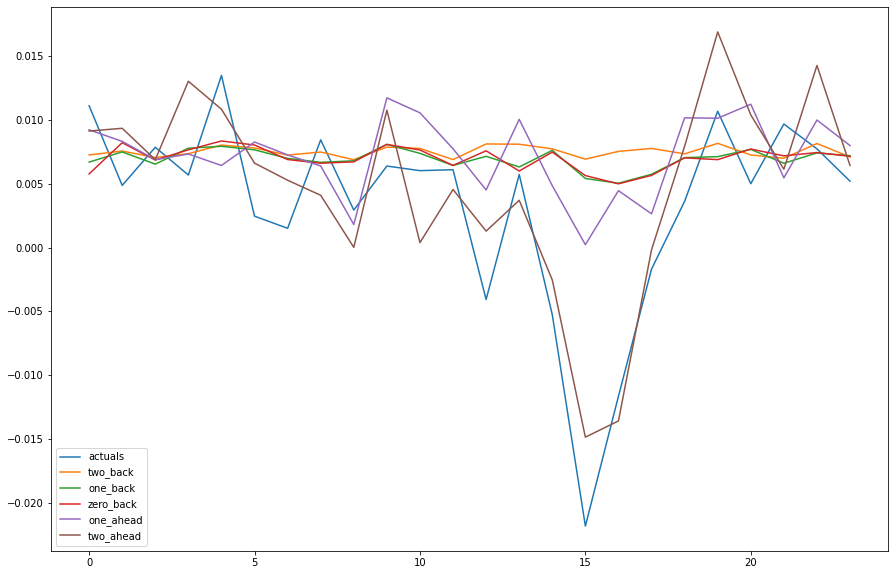

In [10]:
# plot of predictions vs actuals
pd.DataFrame({
    "actuals":actuals, 
    "two_back":pred_dict[-2], 
    "one_back":pred_dict[-1], 
    "zero_back":pred_dict[0],
    "one_ahead":pred_dict[1],
    "two_ahead":pred_dict[2]}
).plot()
;

# Final model usage / getting predictions on new data
Say model selection is finished and the model is to now be used, i.e. used to get predictions on new data.

In [11]:
# the test data ends 2010-12-01, let's say we wanted to predict 2011-03-01
new_data = test.copy()

# the date we want predicted must be in the date, if it's not there it must be added
desired_date = pd.to_datetime("2011-03-01")

while desired_date > np.max(new_data.date):
    new_data.loc[len(new_data), "date"] = np.max(new_data.date) + pd.DateOffset(months=1)

# we can now confirm the date we want to forecast is in the dataframe, even if all values are missing
new_data.tail()

,date,payems,gdpc1,cpiaucsl,unrate,houst,indpro,dspic96,cpilfesl,pcepilfe,pcepi,permit,ulcnfb,a261rx1q020sbea
766,2010-11-01,0.000957,NaN,0.002534,0.042553,0.003683,0.000453,0.000845,0.001438,0.001300,0.001997,0.003584,NaN,NaN
767,2010-12-01,0.000551,0.005196,0.004017,-0.051020,-0.011009,0.009657,0.005819,0.000873,0.000206,0.002263,0.128571,0.001172,0.002461
768,2011-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
769,2011-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
770,2011-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# now transform the data into the appropriate format for the model
transformed_new_data = mean_fill_dataset(new_data, new_data) # we can use the latest data for mean filling, since this isn't for model assessment but inference
transformed_new_data = flatten_data(transformed_new_data, target_variable, 4)

In [13]:
# obtain prediction for the new period
# drop all data but period we're interested in
new_x = transformed_new_data.loc[transformed_new_data.date == "2011-03-01", :].drop(["date", target_variable], axis=1)
preds = []
for i in range(10):
    preds.append(models[i].predict(new_x)[0])
np.nanmean(preds)

0.006505433991079668

# Alternative method - separate models for each vintage
Another approach for getting non-timeseries handling models to work in the nowcasting context is to train a different model for each data vintage. I.e., if the our nowcasting lifecycle spans 5 months, starting two months before the target date until two months after the target date, having five different models, one trained only with data that would be available two months before the target date, one month before the target date, as of the target date, and one and two month after. The last model would continue to be used once all data for the quarter would be in the model. E.g. if we're nowcasting Q2 2020, June 2020, we use the two month before model (which is only trained with data up to four lags behind the target date) to make our predictions until May 2020. We then switch to the one month ahead model until June 2020, then use the month of model, then the 1 month after model and finally the two month after model. The logic is the following: since we fill missing values with the mean, any values for April, May, and June will be the mean when we're making predictions in April. A model trained with all lags may have learned to glean most of its information from the last month's data, so at this early vintage will have a hard time predicting anything other than the mean. If we use a different model leaving out later months at this early vintage, however, the model will be forced to learn what information it can from the earlier lags.

In this benchmarking test/application, this approach especially boosted gradient boosting's performance, but had a lesser impact on other non-timeseries methodologies like OLS or decision trees. So while it is no panacea, it may be worth trying. The approach is exactly the same for the other methodologies, just substitute the model estimation and prediction code.

In [14]:
# new helper function necessary to prepare the data for the models for the earlier vintages
# truncate to only include date up to a certain lag
def truncate_flattened(flattened, lag, target_variable):
    if lag == 1:
        flattened = flattened.loc[:, ["date"] + list(flattened.columns[flattened.columns.str.contains("_")]) + [target_variable]]
    elif lag == 0:
        flattened = flattened.loc[:, ["date"] + list(flattened.columns[flattened.columns.str.contains("_")]) + [target_variable]]
        flattened = flattened[flattened.columns.drop(list(flattened.filter(regex='_1')))]
    elif lag == -1:
        flattened = flattened.loc[:, ["date"] + list(flattened.columns[flattened.columns.str.contains("_")]) + [target_variable]]
        flattened = flattened[flattened.columns.drop(list(flattened.filter(regex='_1')))]
        flattened = flattened[flattened.columns.drop(list(flattened.filter(regex='_2')))]
    elif lag == -2:
        flattened = flattened.loc[:, ["date"] + list(flattened.columns[flattened.columns.str.contains("_")]) + [target_variable]]
        flattened = flattened[flattened.columns.drop(list(flattened.filter(regex='_1')))]
        flattened = flattened[flattened.columns.drop(list(flattened.filter(regex='_2')))]
        flattened = flattened[flattened.columns.drop(list(flattened.filter(regex='_3')))]

    return flattened

## Training the model

In [15]:
# dictionary object to contain different vintage models
models_dict = {}
for lag in lags:
    transformed_train = mean_fill_dataset(train, train) # fill any missing values with the mean
    transformed_train = flatten_data(transformed_train, target_variable, 4) # 4 means include 4 additional lags of each variable
    # only keep quarterly observations and drop early observations with not enough history for lagged variables
    transformed_train = transformed_train.loc[transformed_train.date.dt.month.isin([3,6,9,12]),:].dropna(axis=0, how="any").reset_index(drop=True)

    # new extra step to drop lags that occur after the data vintage
    transformed_train = truncate_flattened(transformed_train, lag, target_variable)

    # train 10 models to average outputs because of stochasticity
    models = []
    for i in range(10):
        model = GradientBoostingRegressor()

        x = transformed_train.drop(["date", target_variable], axis=1)
        y = transformed_train[target_variable]

        model.fit(x, y)
        models.append(model)
    models_dict[lag] = models

## Testing the model on artificial data vintages

In [16]:
# dates in the test set
dates = (
        pd.date_range(test_start_date, test_end_date, freq="3MS")
        .strftime("%Y-%m-%d")
        .tolist()
    )

# actual values
actuals = list(test.loc[test.date.isin(dates), target_variable].values)

In [17]:
pred_dict = {k: [] for k in lags}
for lag in lags:
    for date in dates:
        # the data available for this date at this artificial vintage
        tmp_data = gen_lagged_data(metadata, test, date, lag)

        # get data in format necessary for model
        tmp_data = mean_fill_dataset(train, tmp_data) # fill with the mean of the training set
        tmp_data = flatten_data(tmp_data, target_variable, 4)
        
        # new extra step to drop lags that occur after the data vintage
        tmp_data = truncate_flattened(tmp_data, lag, target_variable)
        
        x = tmp_data.loc[tmp_data.date == date, :].drop(["date", target_variable], axis=1)
        
        # average results of 10 models' predictions
        preds = []
        for i in range(10):
            prediction = models_dict[lag][i].predict(x)[0] # only change to prediction is to use the correct model for the lag
            preds.append(prediction)
        
        pred_dict[lag].append(np.nanmean(preds))

## Assess and visualize model performance
Comparing theses results to the earlier ones using just one model for all vintages, we can see that performance is improved in every vintage except for 2 months after, which makes sense, since for this vintage the model is exactly the same between the two. The model has a better ability to make predictions different from the mean earlier on because it is not relying on getting most of its information from the last months' data at earlier vintages.

In [18]:
# table of RMSE by vintage
performance = pd.DataFrame(columns=["Vintage", "RMSE"])
for lag in lags:
    tmp = pd.DataFrame({
        "Vintage":lag,
        "RMSE":np.sqrt(np.mean((np.array(actuals) - np.array(pred_dict[lag])) ** 2))
    }, index=[0])
    performance = performance.append(tmp).reset_index(drop=True)
performance.round(4)

,Vintage,RMSE
0,-2,0.0075
1,-1,0.0063
2,0,0.0069
3,1,0.0061
4,2,0.0043


''

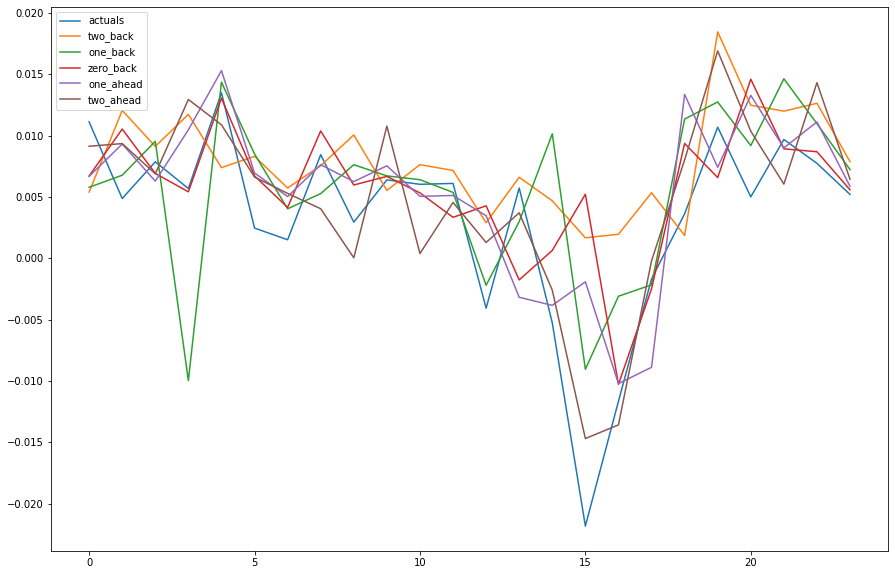

In [19]:
# plot of predictions vs actuals
pd.DataFrame({
    "actuals":actuals, 
    "two_back":pred_dict[-2], 
    "one_back":pred_dict[-1], 
    "zero_back":pred_dict[0],
    "one_ahead":pred_dict[1],
    "two_ahead":pred_dict[2]}
).plot()
;

## Final model usage / getting predictions on new data
Say model selection is finished and the model is to now be used, i.e. used to get predictions on new data.

In [20]:
# the test data ends 2010-12-01, let's say we wanted to predict 2011-03-01
new_data = test.copy()

# with full data for December 2010, that means we're currently in February 2010
# so the vintage model we want to use it that of -1
which_model_vintage = -1

# the date we want predicted must be in the date, if it's not there it must be added
desired_date = pd.to_datetime("2011-03-01")

while desired_date > np.max(new_data.date):
    new_data.loc[len(new_data), "date"] = np.max(new_data.date) + pd.DateOffset(months=1)

# we can now confirm the date we want to forecast is in the dataframe, even if all values are missing
new_data.tail()

,date,payems,gdpc1,cpiaucsl,unrate,houst,indpro,dspic96,cpilfesl,pcepilfe,pcepi,permit,ulcnfb,a261rx1q020sbea
766,2010-11-01,0.000957,NaN,0.002534,0.042553,0.003683,0.000453,0.000845,0.001438,0.001300,0.001997,0.003584,NaN,NaN
767,2010-12-01,0.000551,0.005196,0.004017,-0.051020,-0.011009,0.009657,0.005819,0.000873,0.000206,0.002263,0.128571,0.001172,0.002461
768,2011-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
769,2011-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
770,2011-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# now transform the data into the appropriate format for the model
transformed_new_data = mean_fill_dataset(new_data, new_data) # we can use the latest data for mean filling, since this isn't for model assessment but inference
transformed_new_data = flatten_data(transformed_new_data, target_variable, 4)

# additional step to truncate data for correct vintage model
transformed_new_data = truncate_flattened(transformed_new_data, which_model_vintage, target_variable)

In [22]:
# obtain prediction for the new period
# drop all data but period we're interested in
new_x = transformed_new_data.loc[transformed_new_data.date == "2011-03-01", :].drop(["date", target_variable], axis=1)
preds = []
for i in range(10):
    preds.append(models_dict[which_model_vintage][i].predict(new_x)[0]) # select correct vintage model from list to make predictions
np.nanmean(preds)

0.0070915842313910476